## Modes in bent waveguides

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FModes_bent_angled.ipynb).

Here, we illustrate how we can use the `ModeSource` and `ModeMonitor` objects to study modes in bent waveguides.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web

Using Tidy3D credentials from stored file


### Bent waveguide setup

First, we will study mode injection and decomposition in a microring. We start by defining various simulation parameters, and the structures that enter the simulation. We simulate a silicon ring on a silicon oxide substrate, and the ring is defined using two Cylinders.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.9
# Radius of the simulated ring
radius = 2 

# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=3.48**2)
mat_sub = td.Medium(permittivity=1.45**2)

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction
sim_length = radius + 1.5

# Simulation domain size, resolution and total run time
sim_size = [sim_length, 2*(radius + 1.5), 3]
resolution = 40
run_time = 20/fwidth

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2*sim_size[2]-wg_height],
    ),
    medium=mat_sub)

# The ring is made by two cylinders
cyl1 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius - wg_width/2,
        length=wg_height,
        axis=2,
    ),
    medium=td.Medium()
)
cyl2 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius + wg_width/2,
        length=wg_height,
        axis=2,
    ),
    medium=mat_wg
)

### Modal planes in bent waveguides

As usual, when initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. In this example, we also need to define the axis of the bend and the radius of the curvature. The definitions are schematically illustrated in the image below. The bend axis is the axis normal to the plane in which the bend lies, (`'z'` in the diagram below). In the mode specification, it is defined *locally* for the mode plane as one of the two axes tangential to the plane. In the case of bends that lie in the `xy`-plane, the mode plane would be either in `xz` or in `yz`, so in both cases the correct setting is `bend_axis=1`, selecting the global `z`. The bend radius is counted from the center of the mode plane to the center of the curvature, along the tangential axis perpendicular to the bend axis. This radius can also be negative, if the center of the mode plane is smaller than the center of the bend, which is what we will encounter in this example. Finally, we note that the `'forward'` and `'backward'` direction parameter can still be used to distinguish between the two propagation directions as in regular modal sources and monitors.

<img src="img/ring_modes.png" width=800>

In [3]:
# xy-plane frequency-domain field monitor; slightly offset in z for better structure viz below
field_mnt = td.FieldMonitor(
    center=[0, 0, 0.05],
    size=[td.inf, td.inf, 0],
    freqs=[freq0], 
    name='field')

# Flux monitor along the ring propagation direction
flux_mnt = td.FluxMonitor(
    center=[0, radius, 0],
    size=[0, 3, 2],
    freqs=[freq0],
    name='flux')

### Running the simulation 

First, we visualize the simulation to make sure we have set up the device correctly. We will use `'absorber'` boundaries along the x-direction, because these boundaries work better than PML for structures which are not translationally invariant along the boundary normal direction.

[15:29:24] WARNING  No sources in simulation.                               ]8;id=140443;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=729602;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#361\361]8;;\

<Figure size 792x288 with 2 Axes>

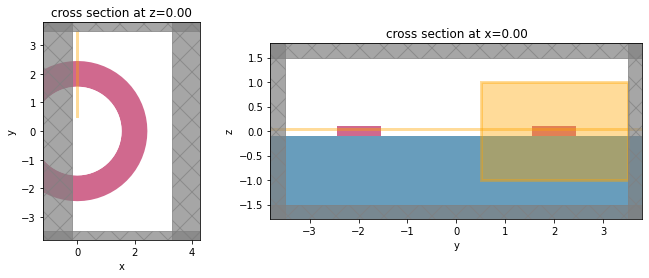

In [4]:
# Simulation
sim = td.Simulation(
    center=[sim_length/2 - 0.2, 0, 0],
    size=sim_size,
    grid_size=3*[1/resolution], 
    structures=[substrate, cyl2, cyl1], 
    sources=[], 
    monitors=[field_mnt, flux_mnt],
    run_time=run_time,
    pml_layers=[td.Absorber(), td.PML(), td.PML()]
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1);
sim.plot(x=0, ax=ax2);

Next, we can compute the source modes to make sure that we inject the desired mode. When a bend radius $R$ is used, the effective index $n$ returned by the solver is such that the field evolves as $e^{i n k_0 R \phi}$, with $\phi$ the polar angle and $k_0 = \omega/c$. This definition is such that in the limit of infinite $R$, the effective index approaches that of a straight waveguide with the same cross-section. Based on our discussion and diagram above, we set the `bend_axis` to `1`, and the `bend_radius` at the position of the source is negative.

<Figure size 1080x864 with 24 Axes>

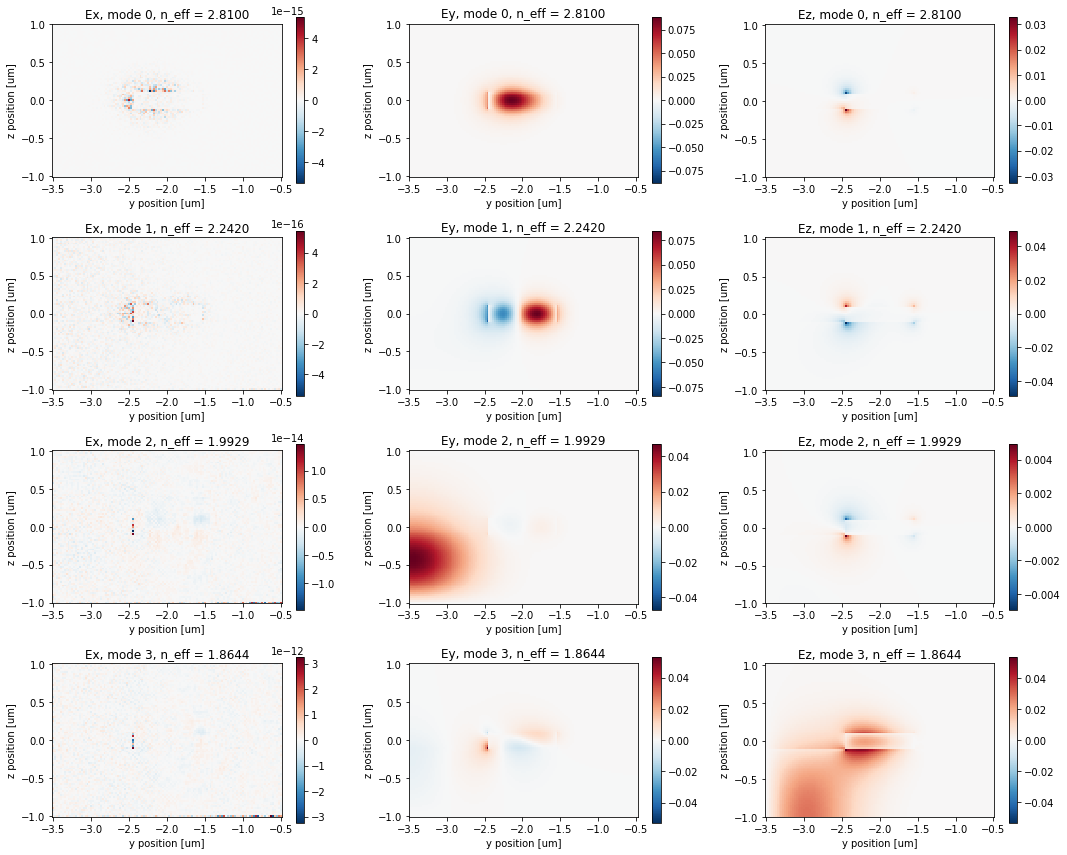

In [5]:
from tidy3d.plugins import ModeSolver

# Modal source plane
source_plane = td.Box(
    center=[0, -radius, 0],
    size=[0, 3, 2]
)

ms = ModeSolver(sim, source_plane, freq0)
num_modes = 4

# NB: negative radius since the plane position is at y=-radius
mode_spec = td.ModeSpec(num_modes=num_modes, bend_radius=-radius, bend_axis=1)

mode_results = ms.solve(mode_spec=mode_spec)
f, axes = plt.subplots(num_modes, 3, tight_layout=True, figsize=(15, 12))
for axe, mode_index in zip(axes, range(num_modes)):
    mode_results_i = mode_results[mode_index]
    for ax, field_name in zip(axe, ('Ex', 'Ey', 'Ez')):
        mode_results_i.field_data.data_dict[field_name].data.real.plot(x='y', ax=ax)
        ax.set_title(f'{field_name}, mode {mode_index}, n_eff = {mode_results_i.n_eff:.4f}')
        ax.set_aspect("equal")

Note that the last two of the computed modes are unphysical. The fundamental mode looks like what we would expect, and we will use that mode for injection. Below, we also define a mode monitor, which is situated radially from the mode source, and so we use a positive value for the bend radius.

In [6]:
# Mode source directly exported from the mode solver above
mode_src = ms.to_source(fwidth=fwidth, mode_spec=mode_spec, mode_index=0, direction='+')

# Mode monitor after one-half round-trip around the ring; NB: positive radius
mode_mnt = td.ModeMonitor(
    center=[0, radius, 0],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=2, bend_radius=radius, bend_axis=1),
    name='modes')

sim.sources = [mode_src]
sim.monitors = [field_mnt, flux_mnt, mode_mnt]

In [7]:
sim_data = web.run(sim, task_name="ring_mode", path='data/sim_data.hdf5')

[15:29:29] INFO     Uploaded task 'ring_mode' with task_id                      ]8;id=338998;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=204554;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    'c813f028-a232-4052-863c-78f43acf7b33'.                                  

[15:29:29] status = queued                                                      ]8;id=37997;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=939730;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#196\196]8;;\

Output()

[15:29:43] status = preprocess                                                  ]8;id=310037;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=441117;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#203\203]8;;\

[15:30:08] status = running                                                     ]8;id=468772;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=386284;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#203\203]8;;\

[15:30:34] status = postprocess                                                 ]8;id=358526;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=660223;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#203\203]8;;\

[15:30:42] status = success                                                     ]8;id=674285;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=428512;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#203\203]8;;\

[15:30:43] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=852328;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114350;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#484\484]8;;\
                    "data/sim_data.hdf5"                                                     

Output()

[15:30:45] INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=237533;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=23982;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#303\303]8;;\

Finally, we visualize the results and verify that we get very close to unity transmission through the half-circle.

Transmission flux:        [0.99830149]
Flux in first two modes:  [9.99695396e-01 1.12682574e-04]


/usr/local/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_in

/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_in

<Figure size 1080x360 with 4 Axes>

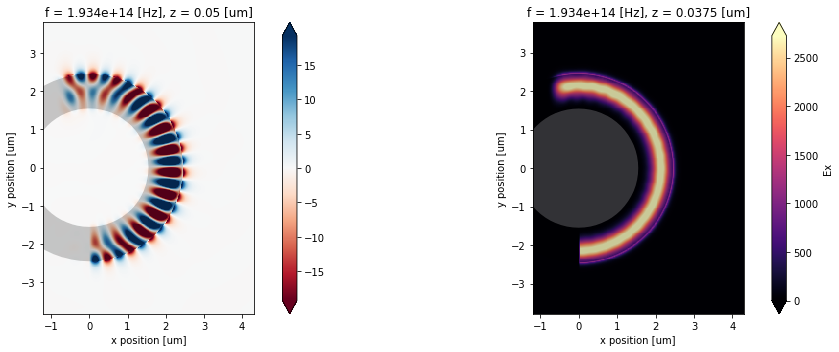

In [8]:
print("Transmission flux:       ", abs(sim_data["flux"].values))
# note: 'backward' mode amplitude
mode_flux = abs(sim_data["modes"].amps.sel(direction="-"))**2
print("Flux in first two modes: ", np.array(mode_flux).ravel()) 

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field('field', 'Ex', z=0.05, freq=freq0, val='real', ax=ax1)
ax2 = sim_data.plot_field('field', 'int', z=0.05, freq=freq0, ax=ax2)

The transmission through the ring is very close to unity, and all the power is in the fundamental ring mode! If needed, we can also access the raw field data e.g. in the `xy`-plane monitor:

In [9]:
sim_data.at_centers("field")

/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_in

/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_in

/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/usr/local/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


<xarray.Dataset>
Dimensions: (f: 1, x: 220, y: 304, z: 1)
Coordinates:
 * f (f) float64 1.934e+14
 * x (x) float64 -1.187 -1.162 -1.137 -1.112 ... 4.212 4.237 4.262 4.287
 * y (y) float64 -3.787 -3.762 -3.737 -3.712 ... 3.712 3.737 3.762 3.787
 * z (z) float64 0.0375
Data variables:
 Ex (x, y, z, f) complex128 (1.1136302976128479e-07-4.57547063406278...
 Ey (x, y, z, f) complex128 (-1.1472991901404811e-08-2.4887265678326...
 Ez (x, y, z, f) complex128 (-1.1640624726372754e-08+2.6971784058232...
 Hx (x, y, z, f) complex128 (-3.4431828701897795e-11+1.4600801256852...
 Hy (x, y, z, f) complex128 (-2.08882389451434e-10+2.605877559230961...
 Hz (x, y, z, f) complex128 (-9.99379297532681e-11+2.540320426558359... xarray.Dataset Dimensions: f : 1 x : 220 y : 304 z : 1 Coordinates: (4) f (f) float64 1.934e+14 units : Hz long_name : frequency array([1.934145e+14]) x (x) float64 -1.187 -1.162 ... 4.262 4.287 units : um long_name : x position array([-1.1875, -1.1625, -1.1375, ..., 4.2375, 4.2625, 4.2875]) y (y) float64 -3.787 -3.762 ... 3.762 3.787 units : um long_name : y position array([-3.7875, -3.7625, -3.7375, ..., 3.7375, 3.7625, 3.7875]) z (z) float64 0.0375 units : um long_name : z position array([0.0375]) Data variables: (6) Ex (x, y, z, f) complex128 (1.1136302976128479e-07-4.575470... array([[[[ 1.11363030e-07-4.57547063e-08j]],

 [[ 5.01798732e-07+3.46668151e-08j]],

 [[ 1.59713475e-06+1.30023555e-06j]],

 ...,

 [[-5.93799657e-07+1.06693098e-06j]],

 [[ 9.22434023e-08+6.81839518e-08j]],

 [[ 8.80558480e-08-2.33006842e-08j]]],


 [[[ 1.37568453e-07-7.10735242e-08j]],

 [[ 6.50725503e-07-9.69177306e-09j]],

 [[ 2.13177368e-06+1.63925751e-06j]],
...
 [[-1.18838221e-06-2.15525552e-06j]],

 [[-6.43896334e-07-3.41174070e-07j]],

 [[-1.14261805e-07-6.04789595e-08j]]],


 [[[ 3.83247253e-08-2.11664650e-08j]],

 [[ 3.02795586e-07-1.31667052e-07j]],

 [[ 1.05313113e-06+4.78616968e-07j]],

 ...,

 [[-8.37216189e-07-1.61876134e-06j]],

 [[-4.50770148e-07-2.91272043e-07j]],

 [[-8.41605108e-08-5.50396425e-08j]]]]) Ey (x, y, z, f) complex128 (-1.1472991901404811e-08-2.48872... array([[[[-1.14729919e-08-2.48872657e-08j]],

 [[ 1.11797251e-07-2.38871771e-07j]],

 [[ 7.76245434e-07-8.05432158e-07j]],

 ...,

 [[-3.04037205e-07+1.19968599e-07j]],

 [[-1.16736498e-07+1.21421808e-07j]],

 [[ 3.09204934e-08+3.18645909e-08j]]],


 [[[-4.31574801e-08-7.64422805e-08j]],

 [[ 3.17126387e-07-7.75472750e-07j]],

 [[ 2.37653706e-06-2.71194846e-06j]],
...
 [[-2.72118872e-06+1.61401894e-06j]],

 [[-5.33571147e-07+5.41671191e-08j]],

 [[-8.19446203e-08+4.49248358e-08j]]],


 [[[ 1.92519211e-08-5.28088573e-08j]],

 [[ 1.06887199e-07+7.21652085e-08j]],

 [[-6.09588337e-08+5.77481772e-07j]],

 ...,

 [[-8.66511208e-07+4.50325073e-07j]],

 [[-1.70538501e-07+9.87678083e-09j]],

 [[-2.66954407e-08+1.24785672e-08j]]]]) Ez (x, y, z, f) complex128 (-1.1640624726372754e-08+2.69717... array([[[[-1.16406247e-08+2.69717841e-08j]],

 [[ 2.16777920e-08+6.75601007e-08j]],

 [[-1.01120299e-07+7.26313139e-07j]],

 ...,

 [[ 5.43594066e-07+1.50482757e-07j]],

 [[ 7.27239506e-09-3.73773161e-08j]],

 [[-5.33786695e-08+4.19265402e-08j]]],


 [[[-3.42765427e-08+8.60245179e-08j]],

 [[ 9.09637217e-08+2.07018125e-07j]],

 [[-2.36964027e-07+2.35723954e-06j]],
...
 [[ 5.54772916e-06-9.35882337e-07j]],

 [[-3.23978995e-07-1.92424126e-06j]],

 [[-2.25832282e-07-9.61425977e-08j]]],


 [[[ 3.94310631e-08+1.24905870e-07j]],

 [[ 5.56895743e-07+7.91442626e-08j]],

 [[ 2.04564179e-06+2.36617599e-07j]],

 ...,

 [[ 1.71503427e-06-2.25875287e-07j]],

 [[-7.40635554e-08-5.90467268e-07j]],

 [[-6.70617450e-08-3.48703153e-08j]]]]) Hx (x, y, z, f) complex128 (-3.4431828701897795e-11+1.46008... array([[[[-3.44318287e-11+1.46008013e-11j]],

 [[ 7.61370303e-11-7.60804887e-11j]],

 [[-3.28105038e-10+8.98436518e-12j]],

 ...,

 [[-3.46927187e-10-4.57303722e-10j]],

 [[-2.40569573e-10+1.61722811e-10j]],

 [[ 1.06112576e-10-1.65312709e-11j]]],


 [[[-1.11935362e-10+4.57105399e-11j]],

 [[ 2.46787533e-1